In [6]:
%matplotlib widget

import sys  
sys.path.insert(0, '/home/cbisot/pycode/MscThesis/')
import pandas as pd
from amftrack.util import get_dates_datetime, get_dirname
import ast
from amftrack.plotutil import plot_t_tp1
from scipy import sparse
from datetime import datetime
from amftrack.pipeline.functions.node_id import orient
import pickle
import scipy.io as sio
from pymatreader import read_mat
from matplotlib import colors
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import frangi
from skimage import filters
from random import choice
import scipy.sparse
import os
from amftrack.pipeline.functions.extract_graph import from_sparse_to_graph, generate_nx_graph, sparse_to_doc
from skimage.feature import hessian_matrix_det
from amftrack.pipeline.functions.experiment_class_surf import Experiment, Edge, Node, Hyphae, plot_raw_plus, get_hyphae
from amftrack.pipeline.paths.directory import run_parallel, find_state, directory_scratch, directory_project
from amftrack.notebooks.analysis.util import * 
from scipy import stats
from scipy.ndimage.filters import uniform_filter1d
from amftrack.pipeline.functions.hyphae_id_surf import get_pixel_growth_and_new_children
from collections import Counter
from IPython.display import clear_output
from amftrack.notebooks.analysis.data_info import *
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
plt.rcParams.update({
    "font.family": "verdana",
'font.weight' : 'normal',
'font.size': 20})
from amftrack.plotutil import plot_node_skel
from util import *

In [3]:
directory_project = "/projects/0/einf914/to_save/"
lapse = 58
exp = get_exp((38,0,0+lapse),directory_project)
exp.directory = directory_project
hyphaes, problems = get_hyphae(exp)
exp.hyphaes = hyphaes

begin = 2021-08-18 13:24:00 
  end = 2021-08-23 15:24:00
0.0
0.29806259314456035
0.5961251862891207
0.8941877794336811
Detected problems during hyphae detection, 10 hyphaes have inconsistent root over time


In [27]:
hyph.end.neighbours(39)

[Node(4079)]

In [41]:
G.subgraph(nx.node_connected_component(G, neighbour.label))

12


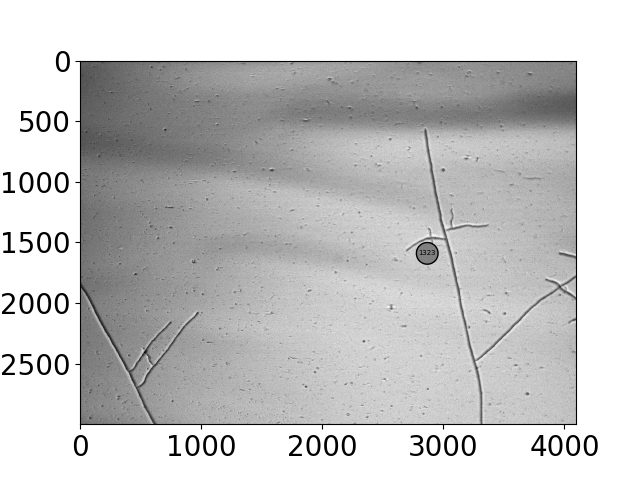

60


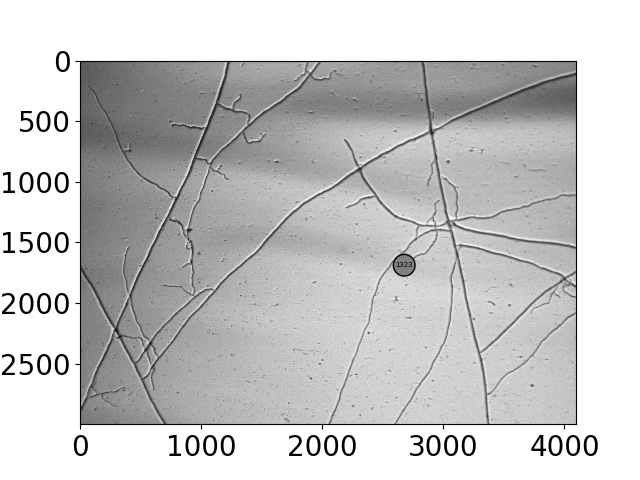

In [121]:
plt.close('all')
# hyph = choice(exp.hyphaes)
# hyph = [hypha for hypha in exp.hyphaes if hypha.end.label == 2885][0]
junctions_found =[]
t0 = hyph.ts[0]
print(t0)
hyph.end.show_source_image(t0,t0)
current_neighbour = hyph.end.neighbours(hyph.ts[0])[0]
for t in hyph.ts[1:]:
    if hyph.end.degree(t)==1:
        neighbour = hyph.end.neighbours(t)[0]
        dist = np.linalg.norm(neighbour.pos(neighbour.ts()[-1])-current_neighbour.pos(current_neighbour.ts()[-1]))
        if neighbour != current_neighbour and dist>20:
            # print(dist,current_neighbour,neighbour)
            # print(t)
            current_neighbour = neighbour
            G = exp.nx_graph[t]
            G = G.subgraph(nx.node_connected_component(G, neighbour.label)) #In the case where there is multiple connected components
            tips = [node for node in neighbour.neighbours(t) if node!= hyph.end and nx.edge_connectivity(G,neighbour.label,node.label)==1]
            if len(tips)>1:
                print(t)
                junctions_found.append(current_neighbour.label)
                current_neighbour.show_source_image(t,t)
print(t)
hyph.end.show_source_image(t,t)

In [125]:
Node(4897,exp).degree(30)

3

12


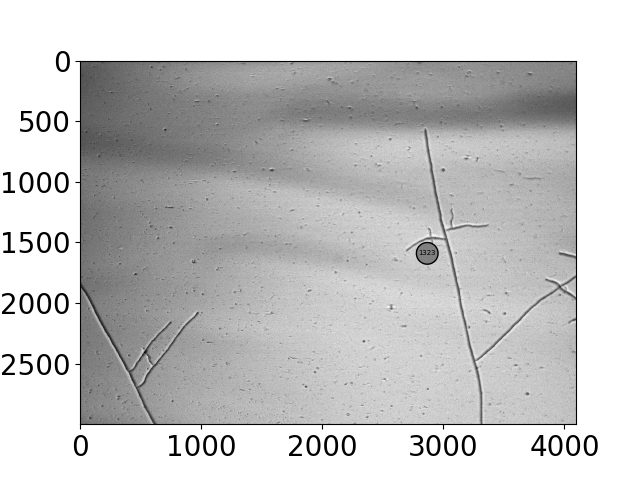

30


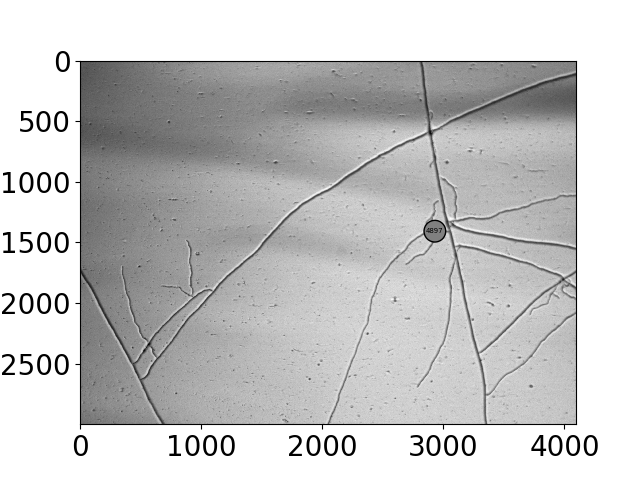

60


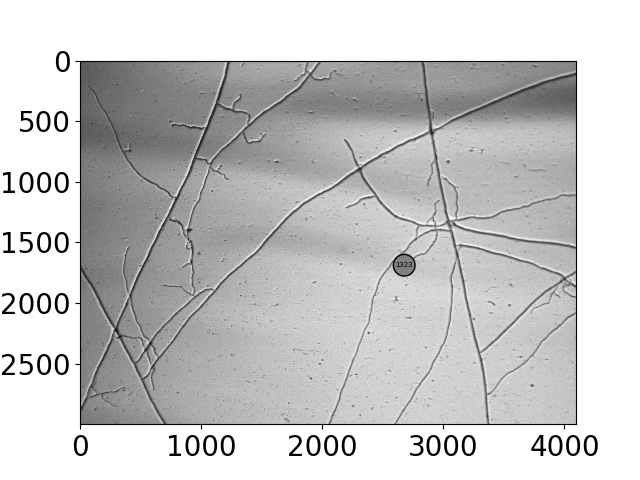

In [123]:
plt.close('all')
# hyph = choice(exp.hyphaes)
# hyph = [hypha for hypha in exp.hyphaes if hypha.end.label == 2885][0]
thresh = 1600
t0 = hyph.ts[0]
print(t0)
hyph.end.show_source_image(t0,t0)
junctions_found= [hyph.end.neighbours(t0)[0]]
for t in hyph.ts[1:]:
    G = exp.nx_graph[t]
    G = G.subgraph(nx.node_connected_component(G, hyph.end.label))
    if hyph.end.degree(t)==1:
        nodes,edges = hyph.get_nodes_within(t)
        potentials = []
        nodes = [Node(node,exp) for node in nodes]
        try:
            last_junction_index = nodes.index(junctions_found[-1])
        except:
            last_junction_index =0 
        for node in nodes[last_junction_index+1:-1]:
            dist = np.linalg.norm(node.pos(t)-hyph.end.pos(t))
            #To avoid detecting two times the same  node with different labels
            dists_junction_found = [np.inf]+[np.linalg.norm(node.pos(t)-nodo.pos(t)) for nodo in junctions_found if nodo.is_in(t)] 
            if dist<thresh and min(dists_junction_found)>20 and(node not in junctions_found):
                extra_hypha_neighbours = [nodo for nodo in node.neighbours(t) if nodo not in nodes]
                tips = [nodo for nodo in extra_hypha_neighbours if nx.edge_connectivity(G,nodo.label,node.label)==1]
                if len(tips) == node.degree(t)-2:
                    print(t)
                    junctions_found.append(node)
                    node.show_source_image(t,t)
print(t)
hyph.end.show_source_image(t,t)
junctions_found= [junction.label for junction in junctions_found]


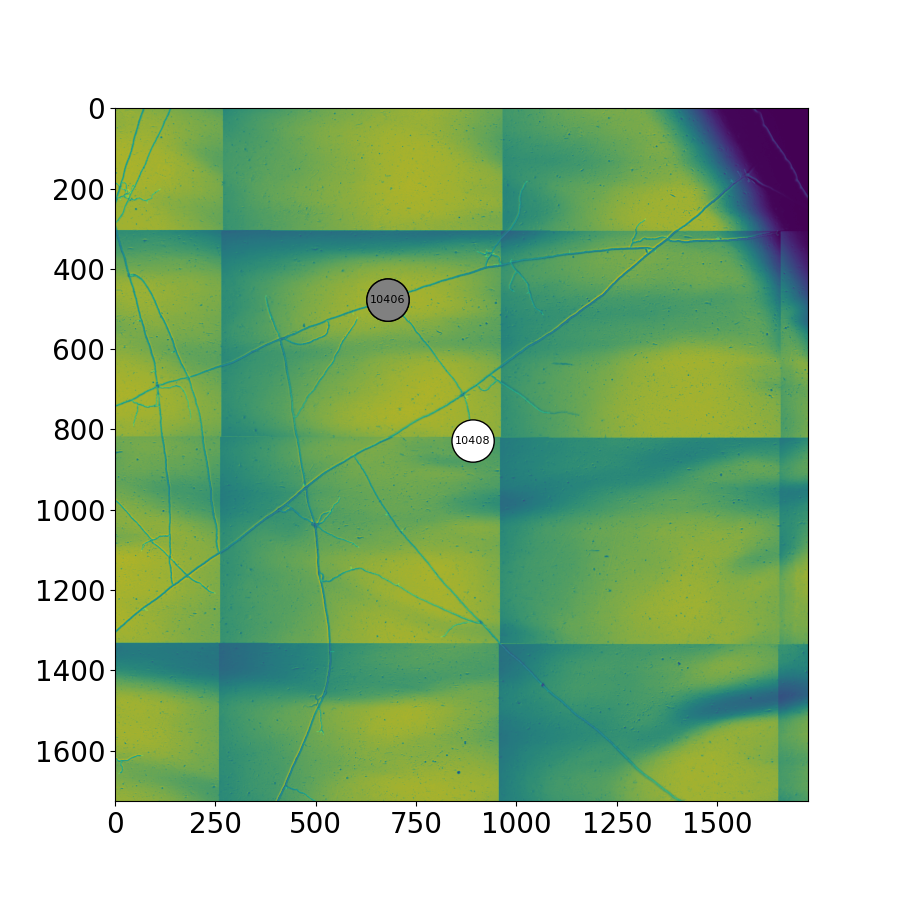

In [115]:
plt.close('all')
ranges = max(2*int(np.linalg.norm(np.array(hyph.root.pos(hyph.ts[-1]))-np.array(hyph.end.pos(hyph.ts[-1])))),500)
compress = 5
tip = hyph.end
fig = plt.figure(figsize = (9,9))
ax = fig.add_subplot(111)
for index,t in enumerate([hyph.ts[-2]]):
    date = exp.dates[t]
    anchor_time = t 
    node_ch = tip
    center = node_ch.pos(anchor_time)[1],node_ch.pos(anchor_time)[0]
    window = (max(0,center[0]-ranges),center[0]+ranges,max(0,center[1]-ranges),center[1]+ranges)
    skelet= get_skeleton_non_aligned(exp,window,t,exp.directory)
    tips = [hyph.end.label]
    junction = [hyph.root.label] + junctions_found 
    # tips = [node.label for node in exp.nodes if t in node.ts() and node.degree(t) ==1 and node.pos(t)[1]>=window[0]-ranges and node.pos(t)[1]<=window[1]+ranges and node.pos(t)[0]>=window[2]-ranges and node.pos(t)[0]<=window[3]+ranges]
    # junction =  [node.label for node in exp.nodes if t in node.ts() and node.degree(t) >=2 and node.pos(t)[1]>=window[0]-ranges and node.pos(t)[1]<=window[1]+ranges and node.pos(t)[0]>=window[2]-ranges and node.pos(t)[0]<=window[3]+ranges]
    directory_name = get_dirname(date,exp.plate)
    path_snap = exp.directory + directory_name
    skel = read_mat(path_snap + "/Analysis/skeleton_pruned_realigned.mat")
    Rot = skel["R"]
    trans = skel["t"]
    im = read_mat(path_snap+'/Analysis/raw_image.mat')['raw']
    size = 8
    ax.imshow(im[(window[2]//compress):(window[3]//compress),(window[0]//compress):(window[1]//compress)])
    ax.imshow(cv2.resize(skelet,(2*ranges//compress,2*ranges//compress)),alpha = 0.2)
    shift=(window[2],window[0])
    greys = [1,0.5]
    for i,node_list in enumerate([tips,junction]):
        grey = greys[i]
        bbox = dict(boxstyle="circle", fc=colors.rgb2hex((grey, grey, grey)))
        #             ax.text(right, top, time,
        #                 horizontalalignment='right',
        #                 verticalalignment='bottom',
        #                 transform=ax.transAxes,color='white')
        for node in node_list:
            #                     print(self.positions[ts[i]])
            if node in exp.positions[t].keys():
                xs,ys = exp.positions[t][node]
                rottrans = np.dot(np.linalg.inv(Rot), np.array([xs, ys] - trans))
                ys, xs = round(rottrans[0]), round(rottrans[1])
                tex = ax.text(
                    (xs - shift[1]) // compress,
                    (ys - shift[0]) // compress,
                    str(node),
                    ha="center",
                    va="center",
                    size=size,
                    bbox=bbox,
                )
plt.show()

In [12]:
neighbour

Node(12160)